In [86]:
import numpy as np
from scipy.optimize import linprog
import matplotlib.pyplot as plt
from util.alg_perf import *
from util.guided_ot import *

ImportError: cannot import name 'milp' from 'scipy.optimize' (/Users/ctaveras/opt/anaconda3/envs/ot-simp/lib/python3.9/site-packages/scipy/optimize/__init__.py)

In [101]:
def get_BHW(SC):
    B_hat, H_hat = np.hstack([SC.B0, -SC.B0]), np.hstack([SC.H, -SC.H])
    W = np.zeros(SC.edge_vec.shape[0])

    for (_, _, w_data) in SC.graph.edges(data=True):
        w_i, idx = w_data['weight'], w_data['idx']
        W[idx] = w_i

    W = W[SC.edge_vec.astype(bool)]
    W_hat = np.hstack([W, W])

    return B_hat, H_hat, W_hat

def pack_x(SC, ref_path):
    x = ref_path.path_edge_vec_seq[:,-1][SC.edge_vec.astype(bool)]
    x_hat = np.zeros(x.shape[0] * 2)
    num_edges = x.shape[0]

    for i in range(x.shape[0]):
        if x[i] > 0:
            x_hat[i] = x[i]
        if x[i] < 0:
            x_hat[i + num_edges] = x[i]

    return x_hat

def homology_path_lp(SC, ref_path, method):
    x_ref_hat = pack_x(SC, ref_path)
    B_hat, H_hat, w_hat = get_BHW(SC)
    print("B shape, H shape, w shape =", B_hat.shape, H_hat.shape, w_hat.shape)
    v_ref = B_hat @ x_ref_hat
    proj_ref = H_hat @ x_ref_hat

    b_eq = np.hstack([proj_ref, v_ref]).T
    print(H_hat.shape, B_hat.shape)
    A_eq = np.vstack([H_hat, B_hat])

    res = linprog(c=w_hat, A_eq=A_eq, b_eq=b_eq, x0=x_ref_hat, method=method) #, cholesky=False, sym_pos=False)
    return res 


def unpack_x(SC, x_hat):
    x_len = x_hat.shape[0]//2
    x = np.zeros(x_len)

    for i in range(x_len):
        if x_hat[i] > 0:
            x[i] = x_hat[i]
        elif x_hat[i] < 0:
            x[i] = -x_hat[i]
    
    print(x, np.max(x), np.min(x))
    x_full = (np.where(SC.edge_vec != 0)[0] + 1) * x
    x_idxs = x_full[x_full != 0].astype(int)
    x_idxs = x_idxs - 1
    x_edges = [SC.edges[e] for e in x_idxs]

    return x, x_edges


# Make domain

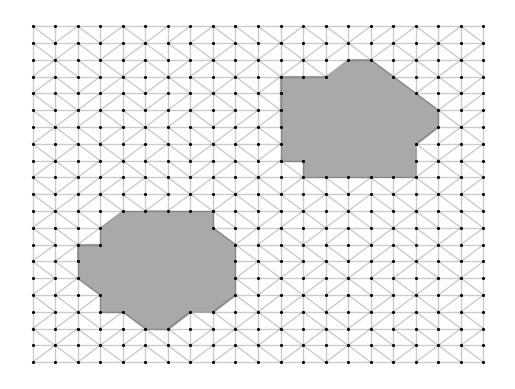

In [91]:
n_side, point_gen_mode = 21, 0

r1, r2 = 0.6, 0.3
n_holes = 2
angle = 2 * np.pi / n_holes
phase = np.pi/4
hole_locs = [(r1 * np.cos(angle * i + phase), r1 * np.sin(angle * i + phase)) for i in range(n_holes)]

# Initialize Simplicial Complex (SC)
pts = generate_pts(point_gen_mode, n_side)
SC = SimplicialComplex(pts, True)
n_side, point_gen_mode = 20, 0

all_faces = np.arange(SC.face_vec.shape[0])
faces_to_add = {2:set(all_faces)}
SC.add_simplices(faces_to_add)
SC.make_holes(hole_locs, r2)

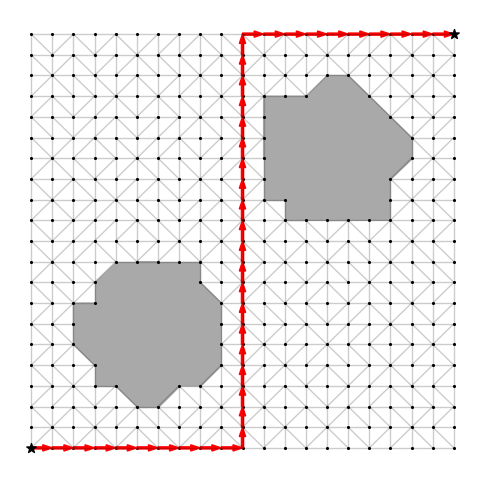

In [92]:
coords1 = np.array([[-1,-1], [0,-1], [0,1], [1,1]])
path1, path1_class, path1_proj, (start, end) = path_from_coords(SC, coords1, 'red', True)

In [97]:
res1 = homology_path_lp(SC, path1, 'interior-point')
res2 = homology_path_lp(SC, path1, 'revised simplex')

B shape, H shape, w shape = (385, 2066) (2, 2066) (2066,)
(2, 2066) (385, 2066)


/Users/ctaveras/opt/anaconda3/envs/ot-simp/lib/python3.9/site-packages/scipy/optimize/_linprog.py:589: OptimizeWarning: x0 is used only when method is 'revised simplex'. 
  warn(warning_message, OptimizeWarning)
/var/folders/yv/d7jz0wl925xf5x_vp0tff0c40000gn/T/ipykernel_19554/2544745255.py:38: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  res = linprog(c=w_hat, A_eq=A_eq, b_eq=b_eq, x0=x_ref_hat, method=method) #, cholesky=False, sym_pos=False)
/var/folders/yv/d7jz0wl925xf5x_vp0tff0c40000gn/T/ipykernel_19554/2544745255.py:38: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
  res = linprog(c=w_hat, A_eq=A_eq, b_eq=b_eq, x0=x_ref_hat, method=method) #, cholesky=False, sym_pos=False)
/var/folders

B shape, H shape, w shape = (385, 2066) (2, 2066) (2066,)
(2, 2066) (385, 2066)


/Users/ctaveras/opt/anaconda3/envs/ot-simp/lib/python3.9/site-packages/scipy/optimize/_linprog_rs.py:354: LinAlgWarning: Diagonal number 41 is exactly zero. Singular matrix.
  B = BGLU(A, b, maxupdate, mast)


In [102]:
x1_full, x1_edges = unpack_x(SC, res1.x)
x2_full, x2_edges = unpack_x(SC, res2.x)

[3.89005472e-01 6.10994528e-01 2.13306249e-13 ... 4.92943062e-01
 4.92943062e-01 1.00000000e+00] 1.000000000001573 1.5463235493128544e-14
[1. 0. 0. ... 1. 1. 1.] 1.0 0.0


In [111]:
SC.H @ x1_full, (SC.B0 @ x1_full)

(array([-0.97476315,  1.12647858]),
 array([-1.00000000e+00,  1.10966791e-13, -1.62291906e-13, -2.60261274e-14,
        -8.43556650e-14, -2.62821869e-14, -6.83178566e-14, -8.46488339e-14,
        -4.35042464e-14, -2.81931460e-14, -6.27741952e-14, -8.06242009e-14,
        -3.03633081e-14, -8.37051134e-14, -3.21132109e-14, -6.00891498e-14,
        -8.43176882e-14, -5.89503497e-14, -3.44528297e-14, -5.98896542e-14,
        -2.51592834e-14, -2.29989756e-14,  6.38655795e-13,  8.74823554e-15,
        -7.01105840e-14,  3.31401573e-14,  5.65813382e-14,  4.75889240e-15,
        -4.94302728e-14,  1.97502480e-15,  5.62587453e-14, -1.57423435e-14,
         1.81929591e-15,  5.01422179e-15,  1.47442599e-15,  1.83875805e-15,
         2.74828641e-14, -2.49857973e-14,  1.12711244e-16,  3.47107433e-16,
         9.26517128e-17,  3.46563377e-14, -2.08237818e-14, -2.09011191e-14,
         9.18232279e-14, -1.08314948e-14,  5.00710584e-14, -1.64490643e-12,
         7.37077066e-13,  2.59883501e-15, -1.0212363

In [106]:
SC.H @ x2_full,np.where(SC.B0 @ x2_full != 0)[0]

array([-1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0